In [2]:
import duckdb
import psutil
import time
import pandas as pd
from pathlib import Path
from statistics import mean, median
from typing import Callable
import tracemalloc
import shutil

def init_duckdb_connection() -> duckdb.DuckDBPyConnection:
    """Инициализация DuckDB соединения"""
    con = duckdb.connect()
    return con

def measure_operation(
    func: Callable,
    warmup: bool = True,
    iterations: int = 3
) -> dict:
    """
    Измерение производительности операции с улучшенной точностью
    
    Args:
        func: Функция для измерения
        warmup: Выполнить прогрев перед измерениями
        iterations: Количество итераций для усреднения
    
    Returns:
        dict с метриками: time, cpu_percent, memory_mb
    """
    process = psutil.Process()
    
    # Прогрев для минимизации cold start эффектов
    if warmup:
        try:
            func()
        except Exception:
            pass  # Прогрев может использовать кэш
    
    times = []
    cpu_usages = []
    memory_usages = []
    
    for _ in range(iterations):
        # Начальное состояние
        cpu_start = process.cpu_percent(interval=0.1)
        tracemalloc.start()
        
        # Измерение
        time_start = time.perf_counter()
        func()
        time_end = time.perf_counter()
        
        # Сбор метрик
        current, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        
        cpu_end = process.cpu_percent(interval=0.1)
        
        times.append(time_end - time_start)
        cpu_usages.append(max(cpu_start, cpu_end))  # Берём максимальное значение
        memory_usages.append(peak / 1024 / 1024)  # MB
        
        # Пауза между итерациями
        time.sleep(0.5)
    
    return {
        'time_mean': round(mean(times), 3),
        'time_median': round(median(times), 3),
        'time_min': round(min(times), 3),
        'time_max': round(max(times), 3),
        'cpu_percent_mean': round(mean(cpu_usages), 2),
        'cpu_percent_max': round(max(cpu_usages), 2),
        'memory_mb_peak': round(max(memory_usages), 2)
    }

def get_file_size_mb(file_path: Path) -> float:
    """Получение размера файла в MB"""
    if file_path.exists():
        return round(file_path.stat().st_size / 1024 / 1024, 2)
    return 0.0

def get_directory_size_mb(directory: Path) -> tuple[float, int]:
    """
    Получение общего размера директории и количества файлов
    
    Returns:
        tuple: (размер в MB, количество файлов)
    """
    total_size = 0
    file_count = 0
    
    if directory.exists():
        for file_path in directory.rglob('*.parquet'):
            total_size += file_path.stat().st_size
            file_count += 1
    
    return round(total_size / 1024 / 1024, 2), file_count

def benchmark_compression_methods(
    source_file: str = 'data.parquet',
    output_dir: str = 'benchmark_results',
    iterations: int = 3,
    cleanup: bool = True
) -> pd.DataFrame:
    """
    Комплексное тестирование методов сжатия
    
    Args:
        source_file: Путь к исходному файлу parquet
        output_dir: Директория для сохранения результатов
        iterations: Количество итераций для каждого теста чтения
        cleanup: Удалять ли директории после теста (для экономии места)
    
    Returns:
        DataFrame с результатами бенчмарка
    """
    
    # Инициализация
    con = init_duckdb_connection()
    source_path = Path(source_file)
    output_path = Path(output_dir)
    
    # Проверка существования исходного файла
    if not source_path.exists():
        raise FileNotFoundError(f"Файл {source_file} не найден!")
    
    # Создание директории для результатов
    output_path.mkdir(exist_ok=True)
    
    # Получение размера исходного файла
    original_size_mb = get_file_size_mb(source_path)
    
    # Получение количества записей
    row_count = con.sql(
        f"SELECT COUNT(*) as cnt FROM read_parquet('{source_path}')"
    ).fetchone()[0]
    
    print(f"\n{'='*80}")
    print(f"📊 Бенчмарк сжатия Parquet")
    print(f"📁 Исходный файл: {source_file}")
    print(f"📏 Размер: {original_size_mb} MB")
    print(f"📈 Записей: {row_count:,}")
    print(f"🔄 Итераций на тест чтения: {iterations}")
    print(f"💾 Результаты сохраняются в: {output_dir}/")
    print(f"{'='*80}\n")
    
    # Конфигурация алгоритмов сжатия
    compressions = [
        # Baseline
        ("uncompressed", "COMPRESSION UNCOMPRESSED", "uncompressed"),
        
        # Быстрые алгоритмы (Hot storage)
        ("snappy", "COMPRESSION SNAPPY", "snappy"),
        ("lz4", "COMPRESSION LZ4", "lz4"),
        
        # Сбалансированные (Warm storage)
        ("gzip", "COMPRESSION GZIP", "gzip"),
        ("zstd-1", "COMPRESSION ZSTD, COMPRESSION_LEVEL 1", "zstd_lvl1"),
        ("zstd-2", "COMPRESSION ZSTD, COMPRESSION_LEVEL 2", "zstd_lvl2"),
        ("zstd-3", "COMPRESSION ZSTD, COMPRESSION_LEVEL 3", "zstd_lvl3"),
        ("zstd-4", "COMPRESSION ZSTD, COMPRESSION_LEVEL 4", "zstd_lvl4"),
        ("zstd-5", "COMPRESSION ZSTD, COMPRESSION_LEVEL 5", "zstd_lvl5"),
        ("zstd-6", "COMPRESSION ZSTD, COMPRESSION_LEVEL 6", "zstd_lvl6"),
        ("zstd-7", "COMPRESSION ZSTD, COMPRESSION_LEVEL 7", "zstd_lvl7"),
        
        # Высокое сжатие (Cold storage)
        ("zstd-8", "COMPRESSION ZSTD, COMPRESSION_LEVEL 8", "zstd_lvl8"),
        ("zstd-9", "COMPRESSION ZSTD, COMPRESSION_LEVEL 9", "zstd_lvl9"),
        ("zstd-10", "COMPRESSION ZSTD, COMPRESSION_LEVEL 10", "zstd_lvl10"),
        ("zstd-11", "COMPRESSION ZSTD, COMPRESSION_LEVEL 11", "zstd_lvl11"),
        ("zstd-12", "COMPRESSION ZSTD, COMPRESSION_LEVEL 12", "zstd_lvl12"),
        ("zstd-13", "COMPRESSION ZSTD, COMPRESSION_LEVEL 13", "zstd_lvl13"),
        ("zstd-14", "COMPRESSION ZSTD, COMPRESSION_LEVEL 14", "zstd_lvl14"),
        ("zstd-15", "COMPRESSION ZSTD, COMPRESSION_LEVEL 15", "zstd_lvl15"),
        
        # Экстремальное сжатие (для сравнения)
        ("zstd-16", "COMPRESSION ZSTD, COMPRESSION_LEVEL 16", "zstd_lvl16"),
        ("zstd-17", "COMPRESSION ZSTD, COMPRESSION_LEVEL 17", "zstd_lvl17"),
        ("zstd-18", "COMPRESSION ZSTD, COMPRESSION_LEVEL 18", "zstd_lvl18"),
        ("zstd-19", "COMPRESSION ZSTD, COMPRESSION_LEVEL 19", "zstd_lvl19"),
        ("zstd-20", "COMPRESSION ZSTD, COMPRESSION_LEVEL 20", "zstd_lvl20"),
        ("zstd-21", "COMPRESSION ZSTD, COMPRESSION_LEVEL 21", "zstd_lvl21"),
        ("zstd-22", "COMPRESSION ZSTD, COMPRESSION_LEVEL 22", "zstd_lvl22"),
    ]
    
    results = []
    
    for name, compression_clause, dir_suffix in compressions:
        test_dir = output_path / dir_suffix
        test_file = test_dir / "data.parquet"
        
        # Создание директории для теста
        test_dir.mkdir(exist_ok=True)
        
        print(f"🔧 [{name.upper()}] Начало теста...")
        
        # === ЗАПИСЬ ===
        sql_write = f"""
            COPY (
                SELECT *
                FROM read_parquet('{source_path}')
            )
            TO '{test_file}' (
                FORMAT PARQUET,
                {compression_clause}
            );
        """
        
        def write_func():
            con.sql(sql_write)
        
        print(f"   ✍️  Запись...")
        write_metrics = measure_operation(write_func, warmup=False, iterations=1)
        
        # Размер сжатого файла
        compressed_size_mb, file_count = get_directory_size_mb(test_dir)
        
        # === ЧТЕНИЕ ===
        def read_func():
            con.sql(f"SELECT COUNT(*) FROM read_parquet('{test_file}');").fetchone()
        
        print(f"   📖 Чтение...")
        read_metrics = measure_operation(read_func, warmup=True, iterations=iterations)
        
        # === РАСЧЁТ МЕТРИК ===
        compression_ratio = round(original_size_mb / compressed_size_mb, 2) if compressed_size_mb > 0 else 0
        space_savings_percent = round((1 - compressed_size_mb / original_size_mb) * 100, 1) if original_size_mb > 0 else 0
        
        write_throughput = round(original_size_mb / write_metrics['time_mean'], 2) if write_metrics['time_mean'] > 0 else 0
        read_throughput = round(compressed_size_mb / read_metrics['time_median'], 2) if read_metrics['time_median'] > 0 else 0
        
        # Комплексная оценка (нормализованная)
        # Формула: (compression_ratio * read_throughput) / (write_time + read_time)
        total_time = write_metrics['time_mean'] + read_metrics['time_median']
        efficiency_score = round(
            (compression_ratio * read_throughput) / total_time,
            2
        ) if total_time > 0 else 0
        
        result = {
            "Compression": name,
            "Write Time (s)": write_metrics['time_mean'],
            "Write CPU (%)": write_metrics['cpu_percent_mean'],
            "Write CPU Max (%)": write_metrics['cpu_percent_max'],
            "Write Memory (MB)": write_metrics['memory_mb_peak'],
            "Read Time (s)": read_metrics['time_median'],
            "Read Time Std (s)": round(read_metrics['time_max'] - read_metrics['time_min'], 3),
            "Read CPU (%)": read_metrics['cpu_percent_mean'],
            "Read CPU Max (%)": read_metrics['cpu_percent_max'],
            "Read Memory (MB)": read_metrics['memory_mb_peak'],
            "File Size (MB)": compressed_size_mb,
            "Original Size (MB)": original_size_mb,
            "Compression Ratio": compression_ratio,
            "Space Savings (%)": space_savings_percent,
            "Write Throughput (MB/s)": write_throughput,
            "Read Throughput (MB/s)": read_throughput,
            "Efficiency Score": efficiency_score,
            "Row Count": row_count,
            "File Count": file_count,
            "Local Path": str(test_file)
        }
        
        results.append(result)
        
        print(f"   ✅ Готово: {compressed_size_mb} MB (ratio: {compression_ratio}x, -{space_savings_percent}%)\n")
        
        # Очистка для экономии места (опционально)
        if cleanup and name not in ['uncompressed', 'zstd-7']:  # Сохраняем baseline и рекомендованный
            shutil.rmtree(test_dir, ignore_errors=True)
    
    con.close()
    
    df = pd.DataFrame(results)
    
    # Добавление рангов для удобства анализа
    df['Rank_Compression'] = df['Compression Ratio'].rank(ascending=False)
    df['Rank_ReadSpeed'] = df['Read Throughput (MB/s)'].rank(ascending=False)
    df['Rank_WriteSpeed'] = df['Write Throughput (MB/s)'].rank(ascending=False)
    df['Rank_Overall'] = df['Efficiency Score'].rank(ascending=False)
    
    return df

# Функция для быстрого анализа результатов
def analyze_results(df: pd.DataFrame) -> None:
    """
    Вывод краткого анализа результатов
    
    Args:
        df: DataFrame с результатами бенчмарка
    """
    print("\n" + "="*80)
    print("📈 АНАЛИЗ РЕЗУЛЬТАТОВ")
    print("="*80)
    
    # Лучшее сжатие
    best_compression = df.loc[df['Compression Ratio'].idxmax()]
    print(f"\n🏆 Лучшее сжатие: {best_compression['Compression']}")
    print(f"   Compression Ratio: {best_compression['Compression Ratio']}x")
    print(f"   Размер: {best_compression['File Size (MB)']} MB")
    print(f"   Экономия: {best_compression['Space Savings (%)']}%")
    
    # Самая быстрая запись
    fastest_write = df.loc[df['Write Throughput (MB/s)'].idxmax()]
    print(f"\n⚡ Самая быстрая запись: {fastest_write['Compression']}")
    print(f"   Throughput: {fastest_write['Write Throughput (MB/s)']} MB/s")
    print(f"   Время: {fastest_write['Write Time (s)']} s")
    
    # Самое быстрое чтение
    fastest_read = df.loc[df['Read Throughput (MB/s)'].idxmax()]
    print(f"\n🚀 Самое быстрое чтение: {fastest_read['Compression']}")
    print(f"   Throughput: {fastest_read['Read Throughput (MB/s)']} MB/s")
    print(f"   Время: {fastest_read['Read Time (s)']} s")
    
    # Лучший баланс
    best_balance = df.loc[df['Efficiency Score'].idxmax()]
    print(f"\n⚖️  Лучший баланс (Efficiency Score): {best_balance['Compression']}")
    print(f"   Score: {best_balance['Efficiency Score']}")
    print(f"   Compression Ratio: {best_balance['Compression Ratio']}x")
    print(f"   Read Throughput: {best_balance['Read Throughput (MB/s)']} MB/s")
    
    # Рекомендации
    print(f"\n💡 Рекомендации:")
    print(f"   • Hot Storage (скорость важнее): {df.nlargest(1, 'Read Throughput (MB/s)')['Compression'].values[0]}")
    print(f"   • Warm Storage (баланс): {best_balance['Compression']}")
    print(f"   • Cold Storage (размер важнее): {best_compression['Compression']}")
    
    print("\n" + "="*80)

# Функция для сохранения результатов
def save_results(df: pd.DataFrame, filename: str = 'benchmark_results.csv') -> None:
    """
    Сохранение результатов в CSV
    
    Args:
        df: DataFrame с результатами
        filename: Имя файла для сохранения
    """
    df.to_csv(filename, index=False)
    print(f"\n💾 Результаты сохранены в: {filename}")

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_compression_analysis(results_df):
    """
    Создание детальных графиков анализа сжатия
    
    Args:
        results_df: DataFrame с результатами бенчмарка
    """
    
    # Настройка стиля
    sns.set_style("whitegrid")
    plt.rcParams['figure.figsize'] = (12, 6)
    plt.rcParams['font.size'] = 10
    
    # ========================================================================
    # График 1: Compression Ratio
    # ========================================================================
    fig1, ax1 = plt.subplots(figsize=(14, 6))
    
    bars = ax1.bar(results_df['Compression'], results_df['Compression Ratio'], 
                   color='steelblue', alpha=0.8, edgecolor='black')
    
    # Добавляем значения на столбцы
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}x',
                ha='center', va='bottom', fontsize=9)
    
    ax1.set_xlabel('Алгоритм сжатия', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Compression Ratio', fontsize=12, fontweight='bold')
    ax1.set_title('📦 Коэффициент сжатия по алгоритмам', fontsize=14, fontweight='bold', pad=20)
    ax1.tick_params(axis='x', rotation=45)
    ax1.axhline(y=1.0, color='red', linestyle='--', linewidth=1.5, label='Baseline (1.0x)')
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # ========================================================================
    # График 2: Write Time (отдельно)
    # ========================================================================
    fig2, ax2 = plt.subplots(figsize=(14, 6))
    
    bars_write = ax2.bar(results_df['Compression'], results_df['Write Time (s)'], 
                         color='coral', alpha=0.8, edgecolor='black')
    
    # Добавляем значения
    for bar in bars_write:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}s',
                ha='center', va='bottom', fontsize=8)
    
    ax2.set_xlabel('Алгоритм сжатия', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Время записи (секунды)', fontsize=12, fontweight='bold')
    ax2.set_title('✍️  Время записи файла', fontsize=14, fontweight='bold', pad=20)
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # ========================================================================
    # График 3: Read Time (отдельно)
    # ========================================================================
    fig3, ax3 = plt.subplots(figsize=(14, 6))
    
    bars_read = ax3.bar(results_df['Compression'], results_df['Read Time (s)'], 
                        color='lightgreen', alpha=0.8, edgecolor='black')
    
    # Добавляем значения
    for bar in bars_read:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}s',
                ha='center', va='bottom', fontsize=8)
    
    ax3.set_xlabel('Алгоритм сжатия', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Время чтения (секунды)', fontsize=12, fontweight='bold')
    ax3.set_title('📖 Время чтения файла', fontsize=14, fontweight='bold', pad=20)
    ax3.tick_params(axis='x', rotation=45)
    ax3.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # ========================================================================
    # График 4: Throughput (Write + Read)
    # ========================================================================
    fig4, ax4 = plt.subplots(figsize=(14, 6))
    
    ax4.plot(results_df['Compression'], results_df['Write Throughput (MB/s)'], 
             marker='o', linewidth=2.5, markersize=8, label='Write Throughput', 
             color='orangered', alpha=0.8)
    ax4.plot(results_df['Compression'], results_df['Read Throughput (MB/s)'], 
             marker='s', linewidth=2.5, markersize=8, label='Read Throughput', 
             color='dodgerblue', alpha=0.8)
    
    ax4.set_xlabel('Алгоритм сжатия', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Throughput (MB/s)', fontsize=12, fontweight='bold')
    ax4.set_title('🚀 Пропускная способность (Write vs Read)', fontsize=14, fontweight='bold', pad=20)
    ax4.tick_params(axis='x', rotation=45)
    ax4.legend(fontsize=11, loc='best')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # ========================================================================
    # График 5: Efficiency Score (отсортирован по убыванию)
    # ========================================================================
    fig5, ax5 = plt.subplots(figsize=(14, 8))
    
    # Сортировка по Efficiency Score
    df_sorted = results_df.sort_values('Efficiency Score', ascending=True)  # ascending=True для горизонтального графика
    
    colors = plt.cm.RdYlGn(df_sorted['Efficiency Score'] / df_sorted['Efficiency Score'].max())
    bars_eff = ax5.barh(df_sorted['Compression'], df_sorted['Efficiency Score'], 
                        color=colors, alpha=0.85, edgecolor='black')
    
    # Добавляем значения
    for i, (bar, value) in enumerate(zip(bars_eff, df_sorted['Efficiency Score'])):
        ax5.text(value, bar.get_y() + bar.get_height()/2, 
                f' {value:.2f}', 
                va='center', ha='left', fontsize=9, fontweight='bold')
    
    ax5.set_xlabel('Efficiency Score', fontsize=12, fontweight='bold')
    ax5.set_ylabel('Алгоритм сжатия', fontsize=12, fontweight='bold')
    ax5.set_title('⚖️  Комплексная оценка эффективности (отсортировано)', 
                  fontsize=14, fontweight='bold', pad=20)
    ax5.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n✅ Все графики построены!")


def plot_comparison_summary(results_df):
    """
    Сводный график сравнения ключевых метрик (опционально)
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. File Size
    axes[0, 0].bar(results_df['Compression'], results_df['File Size (MB)'], 
                   color='mediumpurple', alpha=0.7)
    axes[0, 0].axhline(y=results_df['Original Size (MB)'].iloc[0], 
                       color='red', linestyle='--', label='Original Size')
    axes[0, 0].set_title('Размер файла (MB)', fontweight='bold')
    axes[0, 0].tick_params(axis='x', rotation=45)
    axes[0, 0].legend()
    axes[0, 0].grid(axis='y', alpha=0.3)
    
    # 2. Space Savings
    savings = results_df['Space Savings (%)']
    colors_savings = ['green' if x > 0 else 'red' for x in savings]
    axes[0, 1].bar(results_df['Compression'], savings, color=colors_savings, alpha=0.7)
    axes[0, 1].axhline(y=0, color='black', linewidth=1)
    axes[0, 1].set_title('Экономия места (%)', fontweight='bold')
    axes[0, 1].tick_params(axis='x', rotation=45)
    axes[0, 1].grid(axis='y', alpha=0.3)
    
    # 3. Write + Read Time stacked
    axes[1, 0].bar(results_df['Compression'], results_df['Write Time (s)'], 
                   label='Write', alpha=0.8, color='coral')
    axes[1, 0].bar(results_df['Compression'], results_df['Read Time (s)'], 
                   bottom=results_df['Write Time (s)'],
                   label='Read', alpha=0.8, color='lightgreen')
    axes[1, 0].set_title('Суммарное время (Write + Read)', fontweight='bold')
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].legend()
    axes[1, 0].grid(axis='y', alpha=0.3)
    
    # 4. Compression Ratio vs Efficiency Score (scatter)
    scatter = axes[1, 1].scatter(results_df['Compression Ratio'], 
                                 results_df['Efficiency Score'],
                                 s=200, c=results_df['Read Throughput (MB/s)'], 
                                 cmap='viridis', alpha=0.7, edgecolors='black')
    
    # Подписываем точки
    for i, txt in enumerate(results_df['Compression']):
        axes[1, 1].annotate(txt, 
                           (results_df['Compression Ratio'].iloc[i], 
                            results_df['Efficiency Score'].iloc[i]),
                           fontsize=8, ha='center')
    
    axes[1, 1].set_xlabel('Compression Ratio', fontweight='bold')
    axes[1, 1].set_ylabel('Efficiency Score', fontweight='bold')
    axes[1, 1].set_title('Compression Ratio vs Efficiency', fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)
    
    # Colorbar
    cbar = plt.colorbar(scatter, ax=axes[1, 1])
    cbar.set_label('Read Throughput (MB/s)', rotation=270, labelpad=20)
    
    plt.tight_layout()
    plt.show()
    
    print("\n✅ Сводный график построен!")


📊 Бенчмарк сжатия Parquet
📁 Исходный файл: data.parquet
📏 Размер: 8499.93 MB
📈 Записей: 100,000,000
🔄 Итераций на тест чтения: 3
💾 Результаты сохраняются в: benchmark_results/

🔧 [UNCOMPRESSED] Начало теста...
   ✍️  Запись...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

   📖 Чтение...
   ✅ Готово: 8542.6 MB (ratio: 1.0x, --0.5%)

🔧 [SNAPPY] Начало теста...
   ✍️  Запись...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

   📖 Чтение...
   ✅ Готово: 6496.09 MB (ratio: 1.31x, -23.6%)

🔧 [LZ4] Начало теста...
   ✍️  Запись...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

   📖 Чтение...
   ✅ Готово: 6694.35 MB (ratio: 1.27x, -21.2%)

🔧 [GZIP] Начало теста...
   ✍️  Запись...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

   📖 Чтение...
   ✅ Готово: 4681.03 MB (ratio: 1.82x, -44.9%)

🔧 [ZSTD-1] Начало теста...
   ✍️  Запись...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

   📖 Чтение...
   ✅ Готово: 4537.46 MB (ratio: 1.87x, -46.6%)

🔧 [ZSTD-2] Начало теста...
   ✍️  Запись...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

   📖 Чтение...
   ✅ Готово: 4553.22 MB (ratio: 1.87x, -46.4%)

🔧 [ZSTD-3] Начало теста...
   ✍️  Запись...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

   📖 Чтение...
   ✅ Готово: 4586.47 MB (ratio: 1.85x, -46.0%)

🔧 [ZSTD-4] Начало теста...
   ✍️  Запись...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

   📖 Чтение...
   ✅ Готово: 4644.76 MB (ratio: 1.83x, -45.4%)

🔧 [ZSTD-5] Начало теста...
   ✍️  Запись...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

   📖 Чтение...
   ✅ Готово: 4587.2 MB (ratio: 1.85x, -46.0%)

🔧 [ZSTD-6] Начало теста...
   ✍️  Запись...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

   📖 Чтение...
   ✅ Готово: 4531.74 MB (ratio: 1.88x, -46.7%)

🔧 [ZSTD-7] Начало теста...
   ✍️  Запись...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

   📖 Чтение...
   ✅ Готово: 4520.22 MB (ratio: 1.88x, -46.8%)

🔧 [ZSTD-8] Начало теста...
   ✍️  Запись...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

   📖 Чтение...
   ✅ Готово: 4510.67 MB (ratio: 1.88x, -46.9%)

🔧 [ZSTD-9] Начало теста...
   ✍️  Запись...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

   📖 Чтение...
   ✅ Готово: 4512.76 MB (ratio: 1.88x, -46.9%)

🔧 [ZSTD-10] Начало теста...
   ✍️  Запись...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

   📖 Чтение...
   ✅ Готово: 4490.87 MB (ratio: 1.89x, -47.2%)

🔧 [ZSTD-11] Начало теста...
   ✍️  Запись...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

   📖 Чтение...
   ✅ Готово: 4481.05 MB (ratio: 1.9x, -47.3%)

🔧 [ZSTD-12] Начало теста...
   ✍️  Запись...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

   📖 Чтение...
   ✅ Готово: 4479.0 MB (ratio: 1.9x, -47.3%)

🔧 [ZSTD-13] Начало теста...
   ✍️  Запись...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

   📖 Чтение...
   ✅ Готово: 4474.31 MB (ratio: 1.9x, -47.4%)

🔧 [ZSTD-14] Начало теста...
   ✍️  Запись...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

   📖 Чтение...
   ✅ Готово: 4446.94 MB (ratio: 1.91x, -47.7%)

🔧 [ZSTD-15] Начало теста...
   ✍️  Запись...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

   📖 Чтение...
   ✅ Готово: 4430.51 MB (ratio: 1.92x, -47.9%)

🔧 [ZSTD-16] Начало теста...
   ✍️  Запись...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

   📖 Чтение...
   ✅ Готово: 4211.48 MB (ratio: 2.02x, -50.5%)

🔧 [ZSTD-17] Начало теста...
   ✍️  Запись...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

   📖 Чтение...
   ✅ Готово: 4214.96 MB (ratio: 2.02x, -50.4%)

🔧 [ZSTD-18] Начало теста...
   ✍️  Запись...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

   📖 Чтение...
   ✅ Готово: 4212.81 MB (ratio: 2.02x, -50.4%)

🔧 [ZSTD-19] Начало теста...
   ✍️  Запись...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

   📖 Чтение...
   ✅ Готово: 4212.42 MB (ratio: 2.02x, -50.4%)

🔧 [ZSTD-20] Начало теста...
   ✍️  Запись...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

   📖 Чтение...
   ✅ Готово: 4212.42 MB (ratio: 2.02x, -50.4%)

🔧 [ZSTD-21] Начало теста...
   ✍️  Запись...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

   📖 Чтение...
   ✅ Готово: 4212.42 MB (ratio: 2.02x, -50.4%)

🔧 [ZSTD-22] Начало теста...
   ✍️  Запись...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

   📖 Чтение...
   ✅ Готово: 4212.42 MB (ratio: 2.02x, -50.4%)



,Compression,Write Time (s),Write CPU (%),Write CPU Max (%),Write Memory (MB),Read Time (s),Read Time Std (s),Read CPU (%),Read CPU Max (%),Read Memory (MB),...,Write Throughput (MB/s),Read Throughput (MB/s),Efficiency Score,Row Count,File Count,Local Path,Rank_Compression,Rank_ReadSpeed,Rank_WriteSpeed,Rank_Overall
0,uncompressed,25.250,9.7,9.7,0.05,0.027,0.006,0.00,0.0,0.0,...,336.63,316392.59,12517.02,100000000,1,benchmark_results/uncompressed/data.parquet,26.0,1.0,1.0,4.0
1,snappy,27.308,0.0,0.0,0.03,0.028,0.002,3.27,9.8,0.0,...,311.26,232003.21,11118.09,100000000,1,benchmark_results/snappy/data.parquet,24.0,4.0,4.0,6.0
2,lz4,27.559,0.0,0.0,0.02,0.028,0.007,3.13,9.4,0.0,...,308.43,239083.93,11006.51,100000000,1,benchmark_results/lz4/data.parquet,25.0,3.0,5.0,7.0
3,gzip,77.176,0.0,0.0,0.03,0.029,0.012,0.00,0.0,0.0,...,110.14,161414.83,3805.13,100000000,1,benchmark_results/gzip/data.parquet,23.0,17.0,15.0,15.0
4,zstd-1,27.033,0.0,0.0,0.03,0.025,0.002,0.00,0.0,0.0,...,314.43,181498.40,12543.50,100000000,1,benchmark_results/zstd_lvl1/data.parquet,18.5,11.0,2.0,3.0
5,zstd-2,27.178,0.0,0.0,0.03,0.026,0.003,6.40,9.7,0.0,...,312.75,175123.85,12037.99,100000000,1,benchmark_results/zstd_lvl2/data.parquet,18.5,13.0,3.0,5.0
6,zstd-3,28.251,0.0,0.0,0.02,0.029,0.006,0.00,0.0,0.0,...,300.87,158154.14,10346.01,100000000,1,benchmark_results/zstd_lvl3/data.parquet,20.5,19.0,6.0,8.0
7,zstd-4,29.447,0.0,0.0,0.03,0.022,0.009,0.00,0.0,0.0,...,288.65,211125.45,13110.71,100000000,1,benchmark_results/zstd_lvl4/data.parquet,22.0,6.0,7.0,2.0
8,zstd-5,32.446,0.0,0.0,0.02,0.026,0.003,0.00,0.0,0.0,...,261.97,176430.77,10051.64,100000000,1,benchmark_results/zstd_lvl5/data.parquet,20.5,12.0,8.0,9.0
9,zstd-6,34.668,0.0,0.0,0.02,0.028,0.002,6.53,9.9,0.0,...,245.18,161847.86,8769.71,100000000,1,benchmark_results/zstd_lvl6/data.parquet,15.5,16.0,9.0,11.0



📈 АНАЛИЗ РЕЗУЛЬТАТОВ

🏆 Лучшее сжатие: zstd-16
   Compression Ratio: 2.02x
   Размер: 4211.48 MB
   Экономия: 50.5%

⚡ Самая быстрая запись: uncompressed
   Throughput: 336.63 MB/s
   Время: 25.25 s

🚀 Самое быстрое чтение: uncompressed
   Throughput: 316392.59 MB/s
   Время: 0.027 s

⚖️  Лучший баланс (Efficiency Score): zstd-8
   Score: 14055.77
   Compression Ratio: 1.88x
   Read Throughput: 300711.33 MB/s

💡 Рекомендации:
   • Hot Storage (скорость важнее): uncompressed
   • Warm Storage (баланс): zstd-8
   • Cold Storage (размер важнее): zstd-16



/tmp/ipykernel_222/3191925263.py:40: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  plt.tight_layout()
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


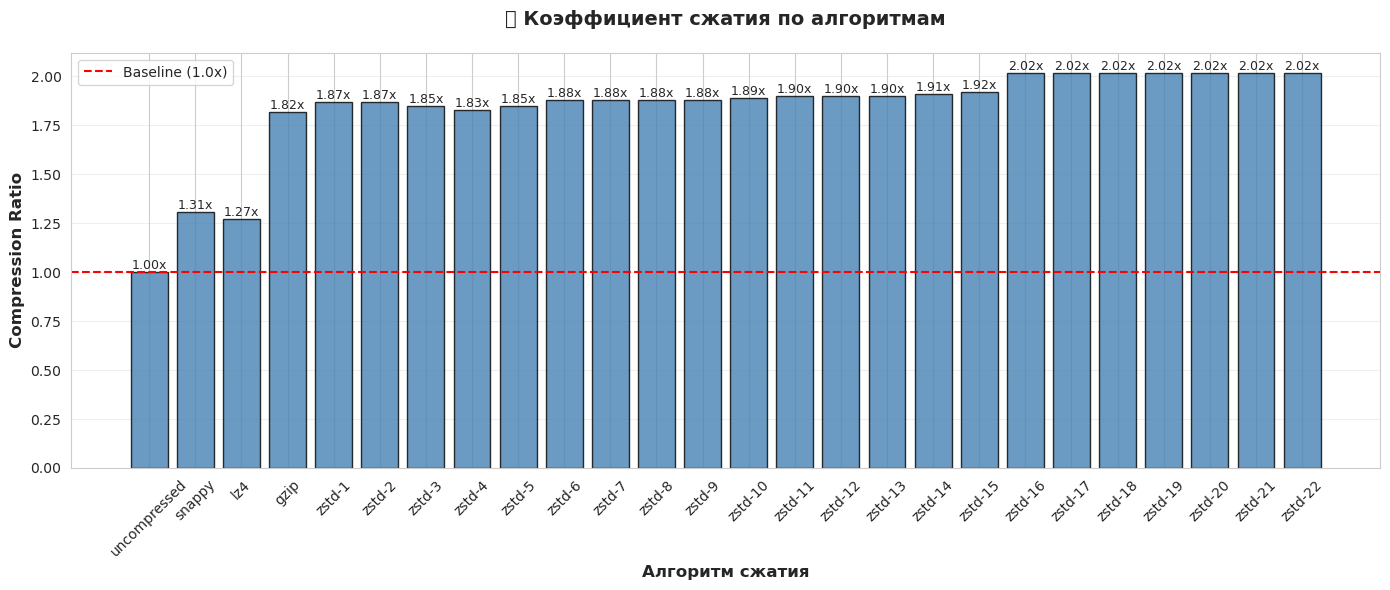

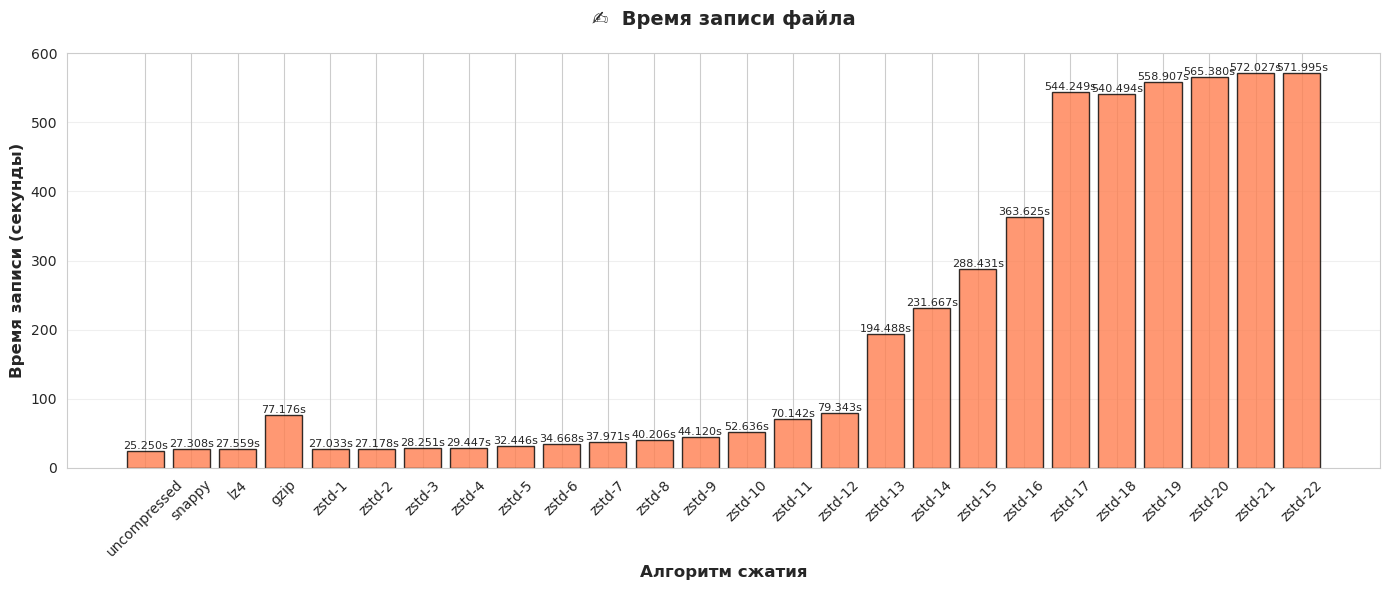

/tmp/ipykernel_222/3191925263.py:88: UserWarning: Glyph 128214 (\N{OPEN BOOK}) missing from current font.
  plt.tight_layout()
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128214 (\N{OPEN BOOK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


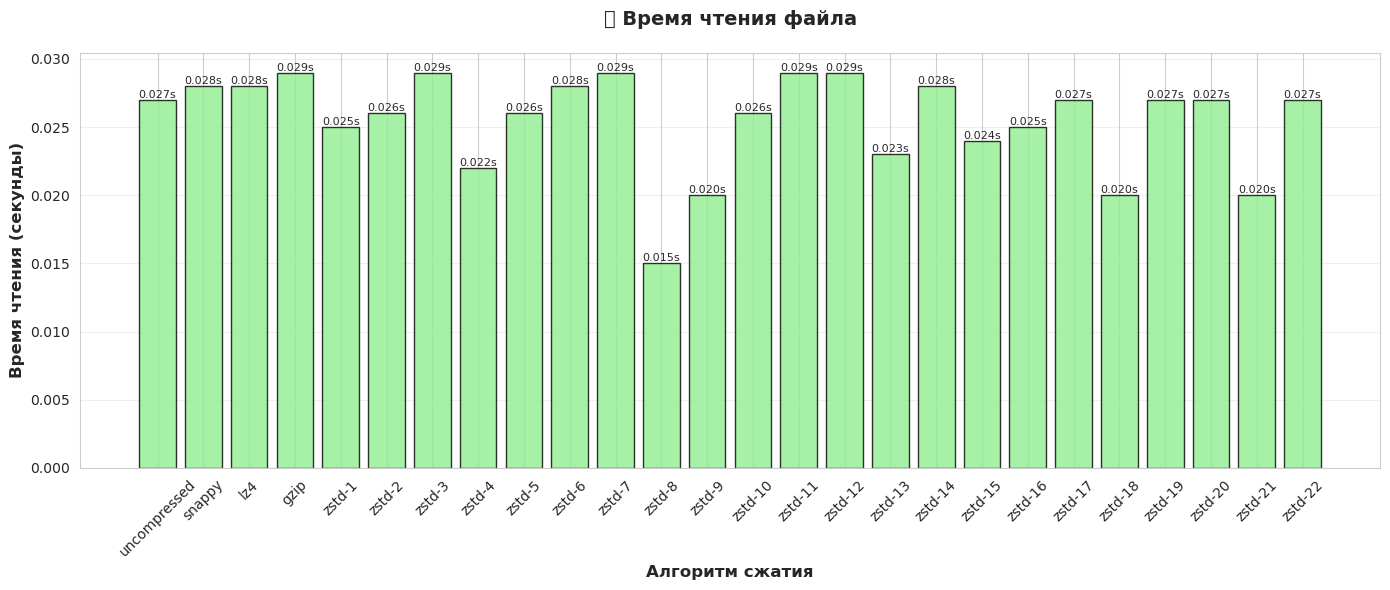

/tmp/ipykernel_222/3191925263.py:110: UserWarning: Glyph 128640 (\N{ROCKET}) missing from current font.
  plt.tight_layout()
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128640 (\N{ROCKET}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


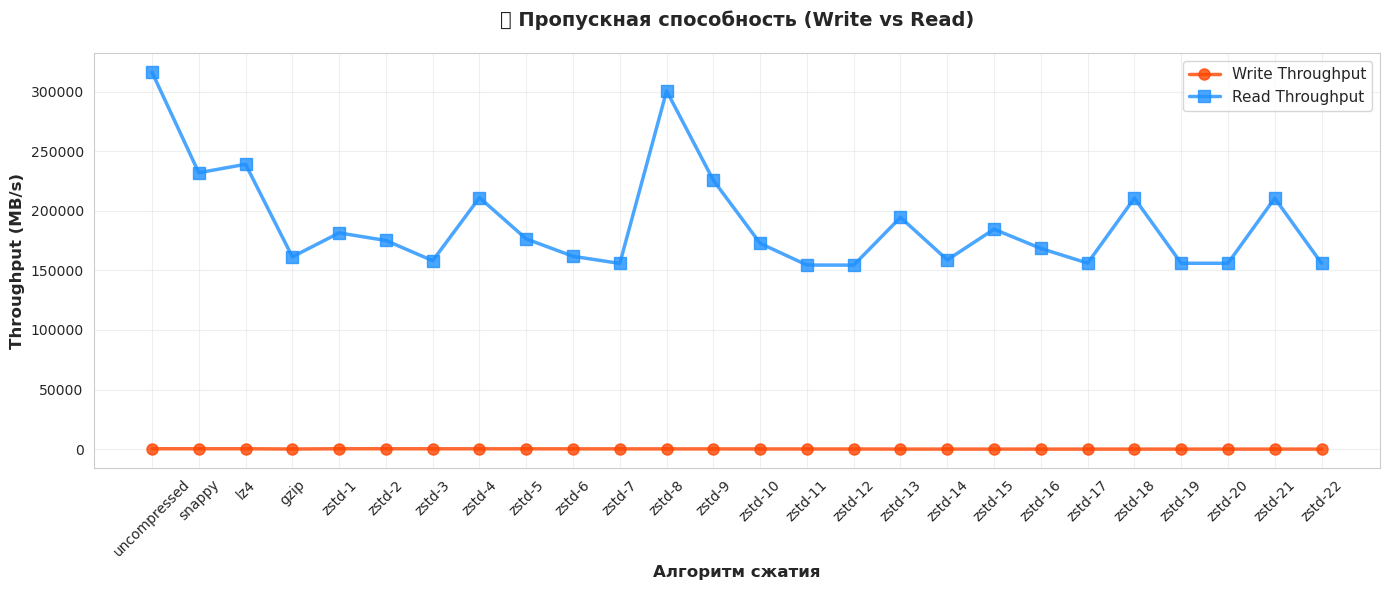

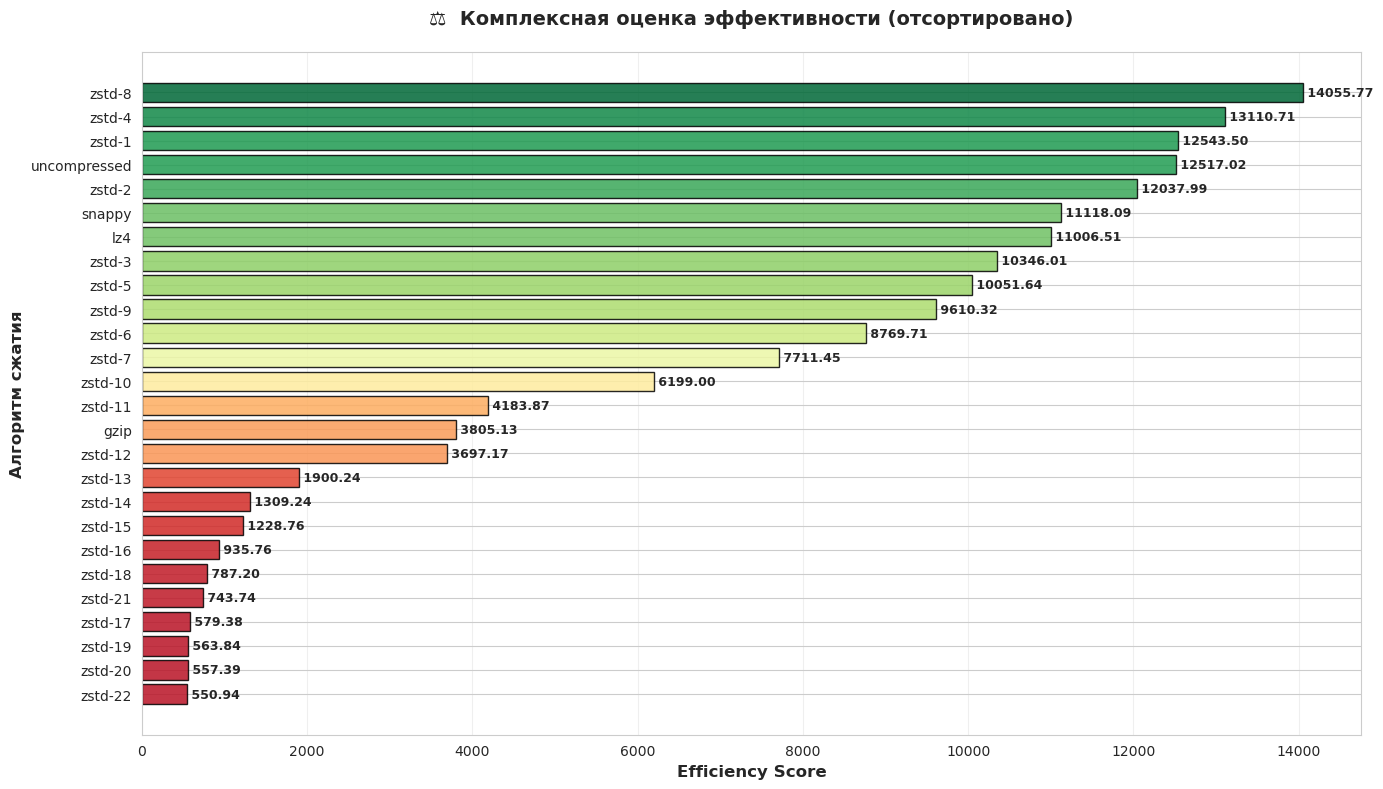


✅ Все графики построены!


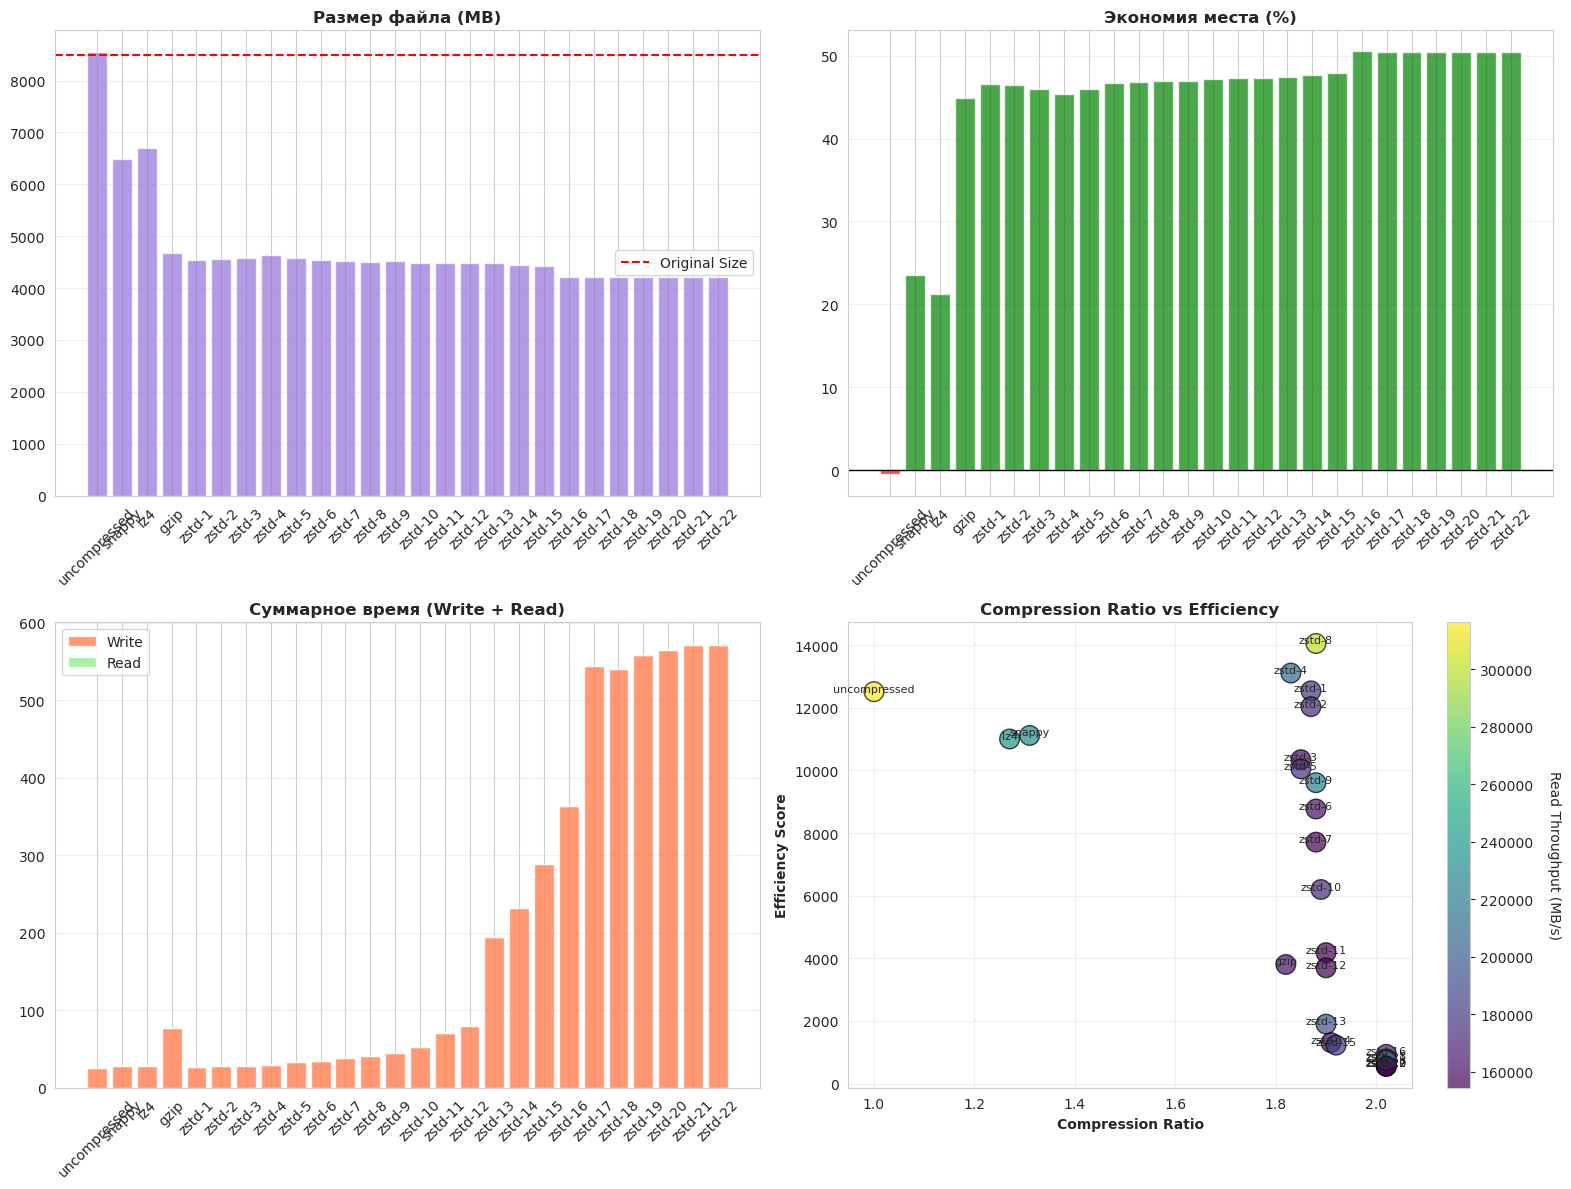


✅ Сводный график построен!

💾 Результаты сохранены в: compression_benchmark.csv


In [4]:
# Ячейка 1: Запуск бенчмарка
results_df = benchmark_compression_methods(
    source_file='data.parquet',
    output_dir='benchmark_results',
    iterations=3,
    cleanup=True
)

# Ячейка 2: Просмотр результатов
display(results_df)

# Ячейка 3: Анализ
analyze_results(results_df)

# Ячейка 4: Основные графики (раздельные)
plot_compression_analysis(results_df)

# Ячейка 5: Сводный график (опционально)
plot_comparison_summary(results_df)

# Ячейка 6: Сохранение
save_results(results_df, 'compression_benchmark.csv')